# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
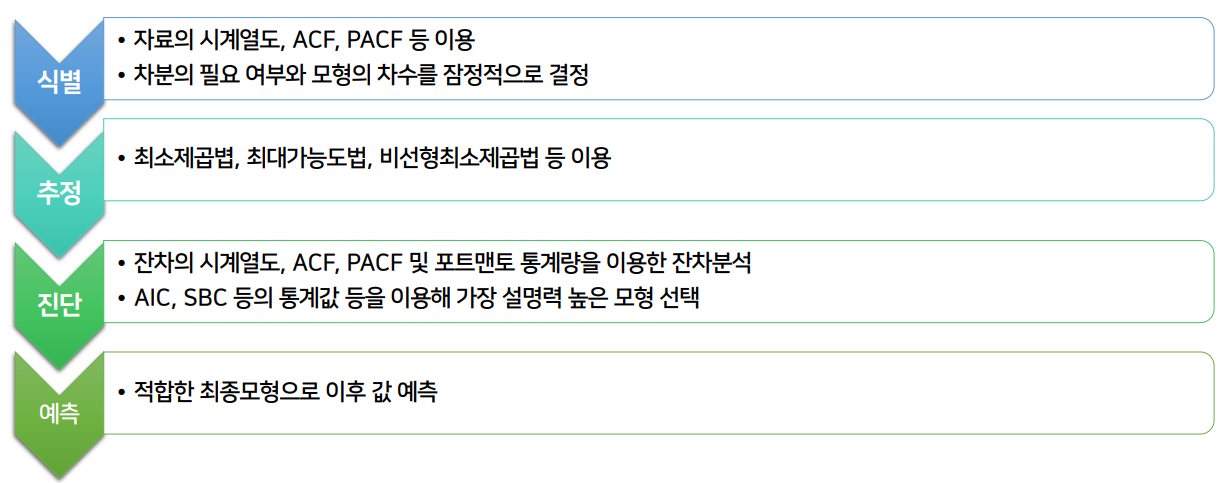

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMAResults

## 데이터 불러오기

In [4]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


# 1. 식별

## 자료의 시계열도

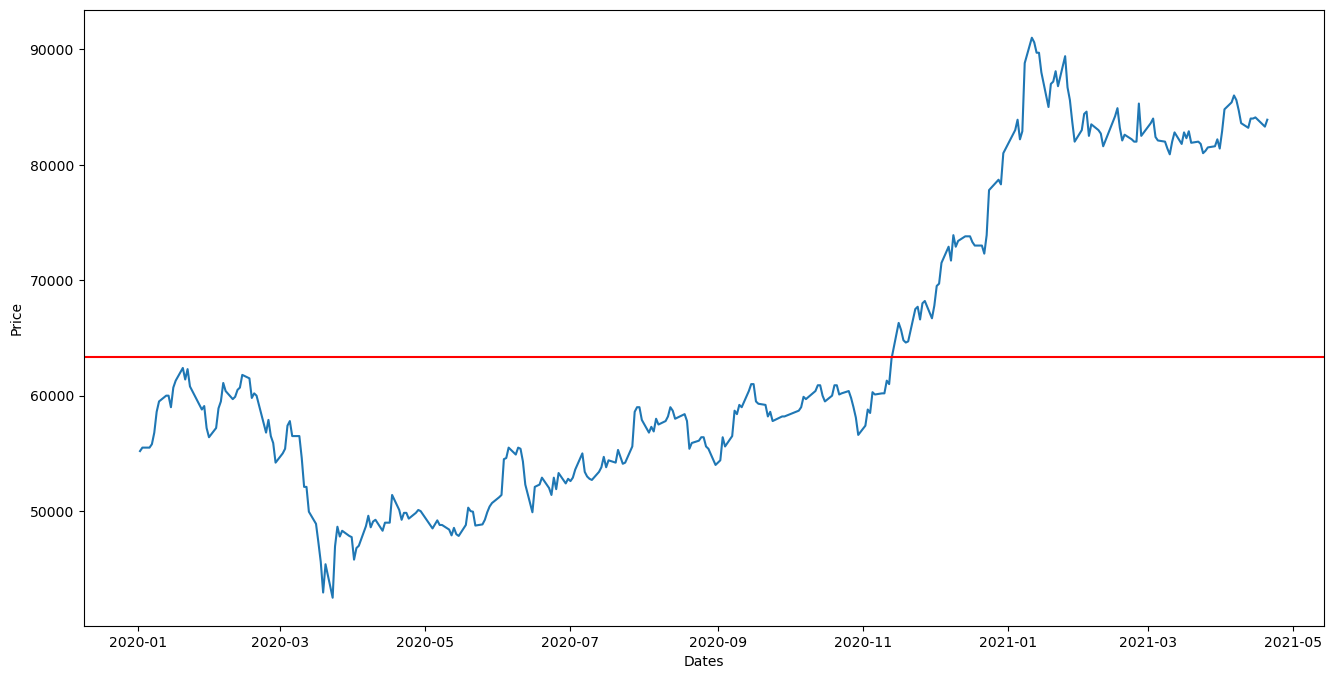

In [5]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
mean_price = np.mean(samsung_df['price'])
ax.axhline(mean_price, color='r')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.show()

- 평균수준이 하나로 유지되는 것이 아니라 시간대별로 평균수준이 달라지며 시계열의 변동폭이 시간대에 따라 다르고 인접한 자료 간에 강한 상관관계가 있는 것으로 보이므로 정상성을 만족하지 않는 것으로 생각할 수 있다.
- 추세, 계절성도 있어보임. 추세의 경우 결정적 추세보다는 증가, 감소가 함께 나타나는 (증가 감소를 반복하는) 확률적 추세로 보임
- 필요한 것: 분산 안정화, 계절차분 (+ 확률적 추세가 맞을 경우 차분)

## 분해

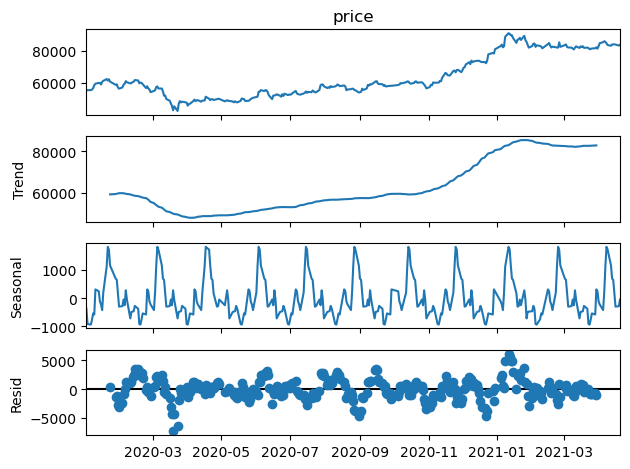

In [11]:
a = seasonal_decompose(samsung_df['price'], model = 'add', period=30)
a.plot();

- 위의 그림을 보아도 추세와 계절성이 존재하고, 잔차가 시간에 따라 패턴을 가지는 것으로 보이므로 정상성을 만족하지 않는다고 판단됨

## 단위근 검정 #1 (Augmented Dicky-Fuller Test 사용)

In [12]:
result = adfuller(samsung_df['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.212189
p-value: 0.937053
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


- H0: 단위근이 없다
- H1: not H0
- p-value가 1에 가까운 큰 값을 가지므로 귀무가설을 기각할 수 있다.   
  따라서 단위근이 존재하며, 확률적 추세를 가지는 비정상 시계열이라고 생각할 수 있다.
- 결론 : 차분에 의한 정상화가 적절

## Sample Correlogram

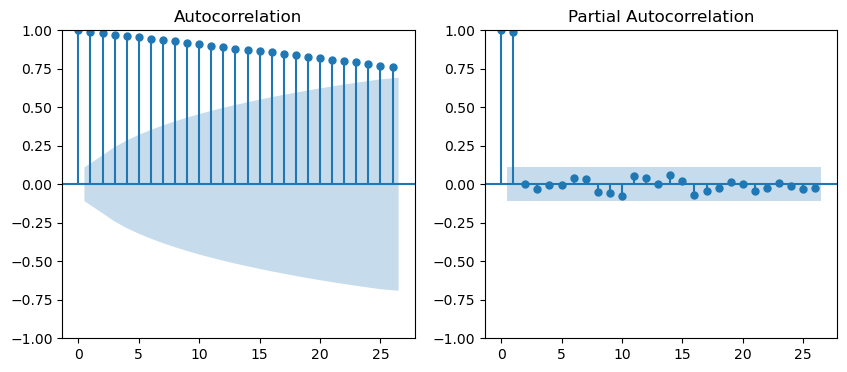

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

# ACF
plot_acf(samsung_df['price'], ax = axes[0])

# PACF
plot_pacf(samsung_df['price'], ax= axes[1])
plt.show()

- SACF가 매우 서서히 감소하므로 비정상 ARIMA 모형으로 생각할 수 있음.  
- SPACF가 p=1 이후에 절단되는 형태를 보이므로 p=1이 적절할 것으로 예상해볼 수 있음.

## 로그 변환 후 1차 차분 수행

In [47]:
# 로그 변환
log_df = np.log(samsung_df[['price']])

# 1차 차분
diff_log_df = log_df.copy()
diff_log_df['price'] = diff_log_df['price'] - diff_log_df['price'].shift(1)
diff_log_df.dropna(axis=0, inplace=True)

#### 처리 후 시계열그림

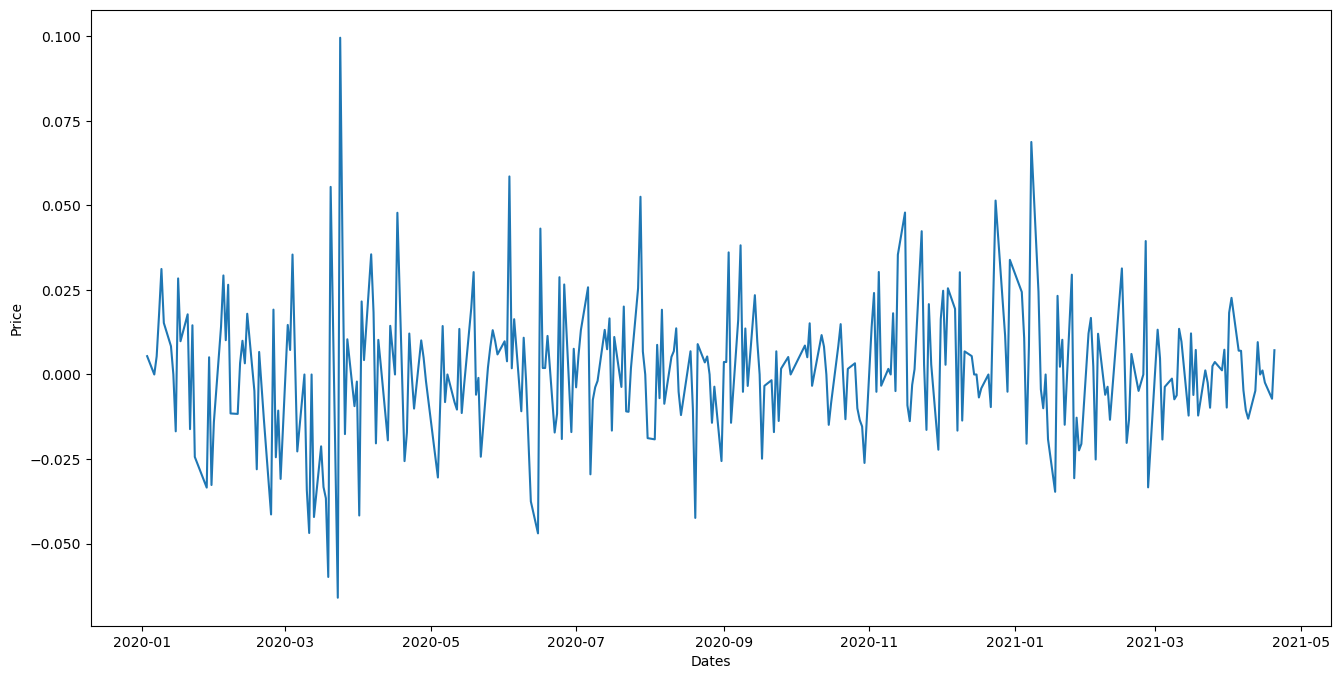

In [49]:
plt.figure(figsize=(16, 8))
plt.plot(diff_log_df.index, diff_log_df["price"], linestyle="-")
plt.xlabel('Dates')
plt.ylabel('Price')
plt.show()

- 추세가 잘 제거된 것으로 보임. (1차 차분만으로 추세가 제거되었으므로 2차 차분은 불필요.) 따라서 ARIMA(p, 1, q) 모형을 사용하기로 함.
- 분산은 로그변환 전보다는 안정되어 보임.
- 원본 데이터에 비해 계절성 또한 뚜렷하지 않아보여 계절차분은 생략하기로 하였음.

## 정상화 후 Sample Correlogram

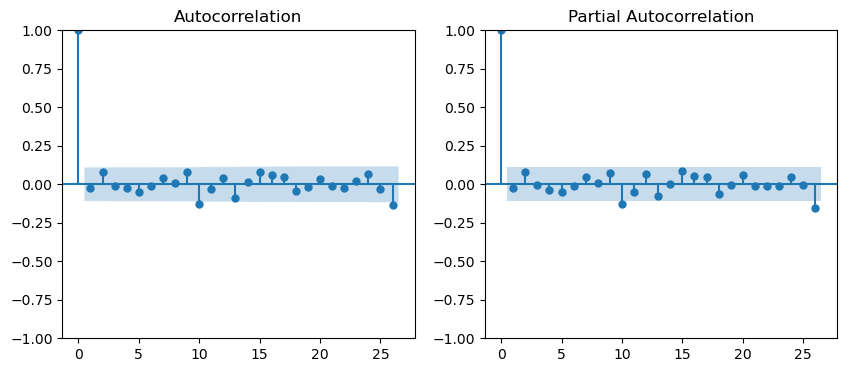

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

# ACF
plot_acf(diff_log_df['price'], ax = axes[0])

# PACF
plot_pacf(diff_log_df['price'], ax= axes[1])
plt.show()

- 표본상관도표를 봤을 때 ACF와 PACF 모두 p=0, q=0 이후 절단되는 형태를 보여 ARIMA(0,1,0) (random walk)도 고려해볼 수 있을 것으로 보임

## 2. 추정

In [77]:
train_data = diff_log_df[:len(diff_log_df)-12]
test_data = diff_log_df[len(diff_log_df)-12:]

In [80]:
arima = auto_arima(train_data, d = 1, start_p=1, start_q=1, max_p=3, max_1=3, m=3, D=1, max_P=3, max_Q=3, 
                   trace=True, stepwise = False, seasonal = False)
result = arima.fit(diff_log_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1299.163, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1501.659, Time=0.44 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1495.488, Time=2.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1408.594, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1495.152, Time=0.89 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1493.803, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1435.482, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1501.666, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1497.982, Time=1.22 sec
 ARIMA(3,1,0)(0,0,0)[0] interce

- ARIMA(2,1,1) 모형이 가장 AIC가 낮은 모델이므로 채택한다.

## 3. 진단

In [81]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  321
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 794.230
Date:                Wed, 30 Aug 2023   AIC                          -1578.460
Time:                        18:21:16   BIC                          -1559.619
Sample:                             0   HQIC                         -1570.936
                                - 321                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.173e-06   3.28e-05      0.036      0.971   -6.31e-05    6.54e-05
ar.L1         -0.0462      0.042     -1.100      0.271      -0.128       0.036
ar.L2          0.0744      0.047      1.581      0.1

- AR 모형의 계수가 유의하지 않은 것으로 나오므로 IMA(1, 1) 모형을 사용해보기로 함.

In [82]:
arima2 = SARIMAX(train_data, order=(0, 1, 1), seasonal_order = (0,0,0,0))
arima_result = arima2.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  309
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 758.914
Date:                Wed, 30 Aug 2023   AIC                          -1513.829
Time:                        18:21:34   BIC                          -1506.368
Sample:                             0   HQIC                         -1510.846
                                - 309                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9950      0.014    -69.599      0.000      -1.023      -0.967
sigma2         0.0004   2.28e-05     18.311      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.20   Jarque-

- 계수가 모두 유의하므로 최종적으로 IMA(1,1) 모형을 채택하기로 함. 

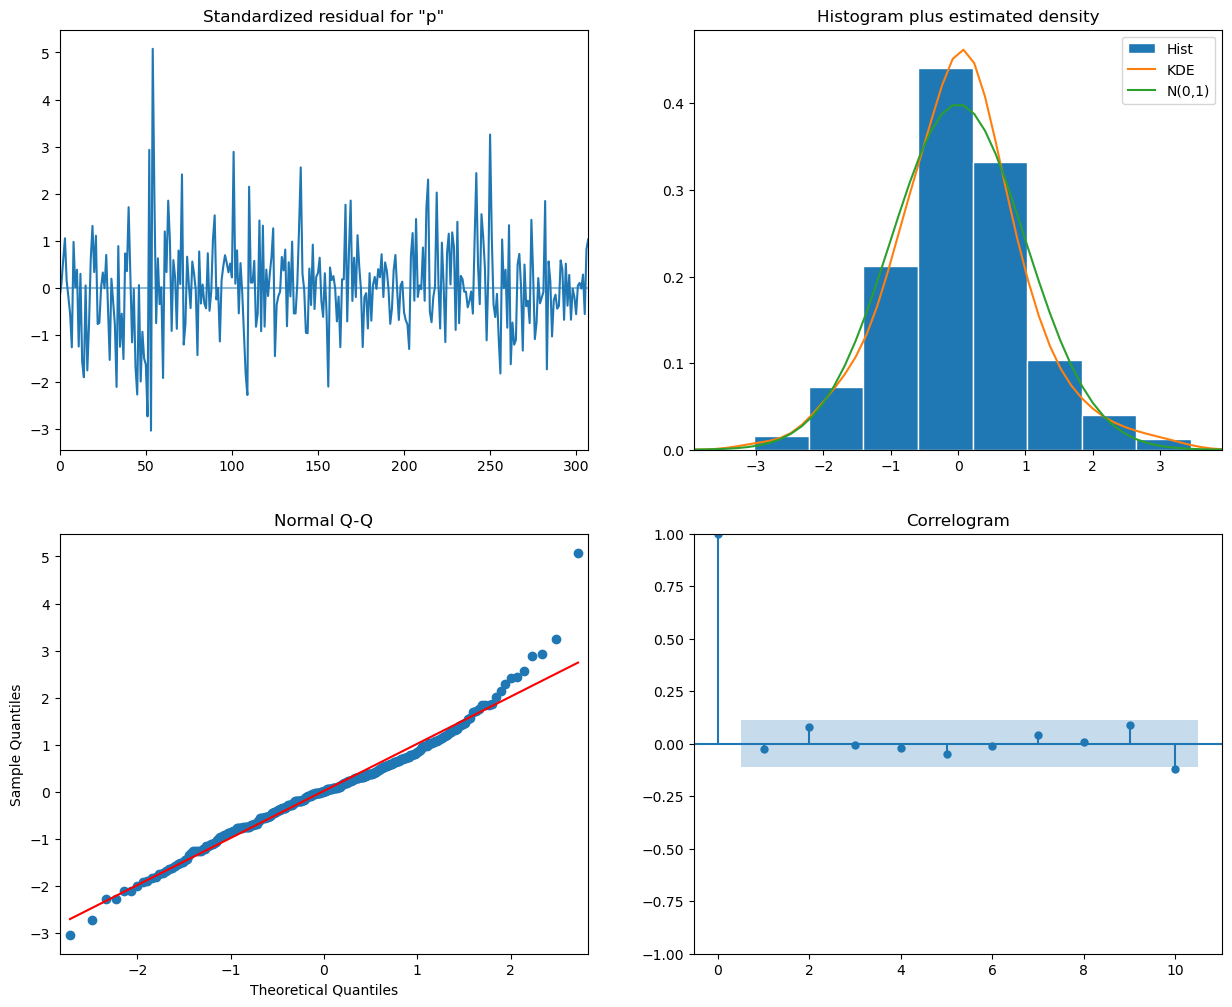

In [83]:
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

- 잔차의 시계열그림이 0을 중심으로 랜덤하게 움직이고, 잔차가 정규성 가정을 만족하는 것으로 볼 수 있고, 잔차의 SACF가 모든 시차에서 유의하지 않으므로 IMA(1,1)은 적절한 모델인 것으로 보인다.

## 4. 예측

In [101]:
test_data

,price
day,
2021-04-05,0.007051
2021-04-06,0.007001
2021-04-07,-0.004662
2021-04-08,-0.010570
2021-04-09,-0.013072
2021-04-12,-0.004796
2021-04-13,0.009569
2021-04-14,0.000000
2021-04-15,0.001190


In [108]:
arima_pred = arima_result.predict(start = len(train_data), end = len(diff_log_df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

309    0.001663
310    0.001663
311    0.001663
312    0.001663
313    0.001663
314    0.001663
315    0.001663
316    0.001663
317    0.001663
318    0.001663
319    0.001663
320    0.001663
Name: ARIMA Predictions, dtype: float64

TypeError: index type not supported

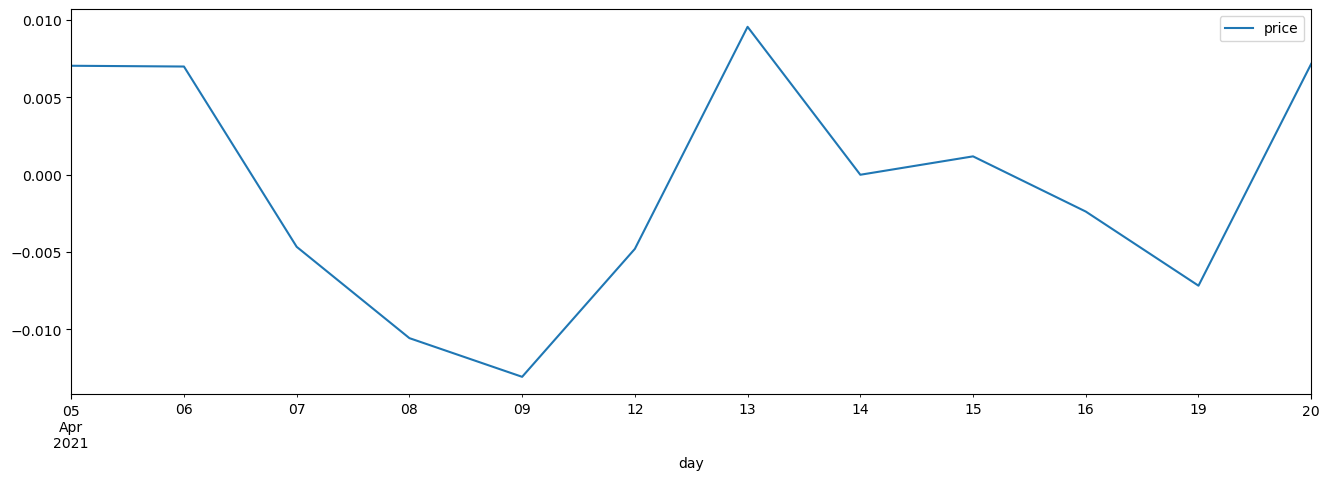

In [110]:
test_data['price'].plot(figsize = (16,5), legend=True)
arima_pred.plot();